# Best performing machine learning models

In [1]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold

2022-04-18 17:34:13.383277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hits/fast/mbm/software/gaussian/g09d1/g09:/hits/fast/mbm/software/gaussian/g09d1/g09:/hits/fast/mbm/software/gaussian/g09d1/g09:
2022-04-18 17:34:13.383302: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
from graphviz import Digraph
import numpy as np
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
print(tf.__version__)

2.4.1


In [4]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-02-08 19:15:36.054931: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-08 19:15:36.067762: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-08 19:15:36.141153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 19:15:36.141961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-02-08 19:15:36.142065: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-08 19:15:36.382424: I tensorflow/stream_executor/platform/def

In [5]:
### Load input data ###
data = pd.read_pickle('data_complete_final')
data.dropna(axis = 1, inplace = True)
data = data.drop(columns = [
    'rad_name', 'h_name', 'hash_u1', 'hash_u2', 'e_max_key', 'e_max', 'e_00', 'e_03', 'e_04',
    'e_05', 'e_06', 'e_07', 'e_10', 'meta_path', 'dG', 'rad_name_s',
    'h_name_s', 'reaction', 'trans_mean', 'Ea_trans_mean', 'rad_ref',
    'rad_ref_idx', 'h_ref', 'h_ref_idx', 'bur_vol_default_rad', 'bur_vol_2A_rad',
    'bur_vol_default_H', 'bur_vol_2A_H'
], axis = 1)

In [6]:
# compute enthalpies of reaction to use as a direct input
BDE_rad = data['rad_BDE']
BDE_H = data['H_BDE']
Delta_H = BDE_H - BDE_rad
Delta_H_df = pd.DataFrame(Delta_H, columns=['Delta_H'])

# Function definitions

In [14]:
def unpack_column(dataframe_in, column):
    dataframe = dataframe_in.reset_index(drop=True)

    if len(dataframe[column][0].shape) > 1:
        max_length = max([len(row[0]) for row in dataframe[column]])
    else:
        max_length = max([len(row) for row in dataframe[column]])

    unpacked = np.empty((len(dataframe[column]), max_length))

    for i, row in zip(range(len(dataframe[column])), dataframe[column]):
        if len(row.shape) > 1:
            row = row[0]

        length_diff = max_length-len(row)
        if length_diff > 0:
            diff = np.zeros(max_length-len(row))
            expanded = np.concatenate((row, diff), axis=1)
            unpacked[i] = expanded
        else:
            unpacked[i] = row

    return pd.DataFrame(unpacked)

def drop_zeros(dataframe):
    df = dataframe.loc[:, (dataframe != 0).any(axis = 0)]
    return df
    
def unpack_join(dataframe, columns):
    unpacked_dfs = []
    for column in columns:
        unpacked_dfs.append(unpack_column(dataframe, column))

    dataframe_compl = dataframe.reset_index(drop=True)
    dataframe_compl.drop(columns = columns, inplace=True)
    for i, df in zip(range(len(unpacked_dfs)), unpacked_dfs):
        dataframe_compl = dataframe_compl.join(df, lsuffix = '_{}'.format(i-1) , rsuffix = '_{}'.format(i))
    
    return dataframe_compl  

def plot_loss(history, no_epochs, title):
    fs = 18
    fig, ax = plt.subplots(figsize = (10,10))
    ax.plot(history.history['loss'], label='Loss')
    ax.plot(history.history['val_loss'], label='Validation loss')
    ax.set_xlim([0, no_epochs])
    ax.set_xlabel('Epoch', fontsize = fs)
    ax.set_ylabel('Error [kcal/mol]', fontsize = fs)
    ax.tick_params(labelsize = fs)
    plt.legend(fontsize = fs)
    plt.grid(True)
    plt.title(title, fontsize = fs)
    plt.show()

def plot_predictions(model, test_features, test_labels, title):
    fs = 18
    fig, ax = plt.subplots(figsize = (10,10))
    test_predictions = model.predict(test_features).flatten()
    ax.scatter(test_predictions, test_labels)
    ax.set_xlabel('Predicted Barrier [kcal/mol]', fontsize = fs)
    ax.set_ylabel('True Barrier [kcal/mol]', fontsize = fs)
    lims = [0, max(test_labels)+10]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims)
    ax.tick_params(labelsize = fs)
    plt.title(title, fontsize = fs)
    plt.show()

def plot_errors(model, test_features, test_labels, title):
    fs = 18
    fig, ax = plt.subplots(figsize = (10,10))
    test_predictions = model.predict(test_features).flatten()
    error = test_predictions - test_labels
    ax.hist(error, bins=5)
    ax.set_xlabel('Prediction error [kcal/mol]', fontsize = fs)
    ax.set_ylabel('Count', fontsize = fs)
    lims = [0, max(test_labels)+10]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims)
    plt.title(title, fontsize = fs)
    plt.show()

def K_fold_cross_validation(
  inputs, targets, num_folds, model, mixed_dtypes, loss='MSLE', metrics = ['mae'], batch_size = 100, no_epochs = 500, verbose = 0,
  split = 0.2, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
):
    mae_per_fold = []
    loss_per_fold = []
  
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=inputs.shape[0]*0.8/batch_size*1000, decay_rate=1, staircase=False
    )
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
  
  
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1)
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
  
        model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)
                    
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if mixed_dtypes:
            # inputs will be a DataFrame
            input_train_dict = {}
            input_train_dict = {name: np.array(value) 
                         for name, value in inputs.iloc[train,:].items()}
    
            history = model.fit(input_train_dict, targets[train],
                        batch_size=batch_size,
                        epochs=no_epochs,
                        verbose=verbose,
                        validation_split=split,
                        callbacks=callbacks)

            input_test_dict = {}
            input_test_dict = {name: np.array(value) 
                         for name, value in inputs.iloc[test,:].items()}

            scores = model.evaluate(input_test_dict, targets[test], verbose=0)

        else:
            # inputs will be a np.array
            history = model.fit(inputs[train], targets[train],
                        batch_size=batch_size,
                        epochs=no_epochs,
                        verbose=verbose,
                        validation_split=split,
                        callbacks=callbacks)
            scores = model.evaluate(inputs[test], targets[test], verbose=0)
        
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
        mae_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])
      
        fold_no = fold_no + 1
    
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(mae_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - MAE: {mae_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> MAE: {np.mean(mae_per_fold)} (+- {np.std(mae_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')
  
    return mae_per_fold, loss_per_fold

NameError: name 'tf' is not defined

In [35]:
def plot_cross_val_scores(dataframe):
    fs = 18
    fig, ax = plt.subplots(figsize=(10,10))
    sns.set_style('ticks')
    ax = sns.violinplot(x="Model", y="MAE [kcal/mol]", data=dataframe, inner=None, orient='v')
    ax = sns.swarmplot(x="Model", y="MAE [kcal/mol]", data=dataframe, color='black', edgecolor='black', size=8)
    ax.tick_params(labelsize = fs)
    ax.set_ylabel('MAE [kcal/mol]', fontsize=fs)
    ax.set_xlabel('Model', fontsize=fs)
    ax.grid(linestyle='--', linewidth=1)

In [10]:
def plot_nn(names, shapes, activations, file_name, title):
    lengths = [len(names), len(shapes), len(activations)]
    lengths_comp = [len(names) for i in range(3)]
    assert np.allclose(lengths, lengths_comp), 'All input lists must be of the same length.'

    dot = Digraph(
        node_attr={'shape': 'box', 'fontname': 'Roboto Light'}, #, 'fillcolor': 'lightblue2', 'style': 'filled'
        graph_attr={'fontname': 'Roboto Light'}
    )
    dot.attr(label=title)
    for i, n, s, a in zip(range(len(names)), names, shapes, activations):
        if s != None:
            dot.node('L{}'.format(i), '{}\n{} Nodes\nActivation: {}'.format(n, s, a))
        else:
            dot.node('L{}'.format(i), '{}'.format(n))

    for i, j in zip(range(len(names)-1), range(1,len(names))):
        dot.edge('L{}'.format(i), 'L{}'.format(j))
        
    dot.format = 'png'
    dot.render(file_name)

# Morgan fingerprints

In [34]:
data_morgan_se = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'morgan_start', 'morgan_end'
]]
data_morgan = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'morgan_start'
]]

data_morgan_se_nomordred = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'morgan_start', 'morgan_end'
]]

data_morgan_nomordred = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'morgan_start'
]]

data_morgan_se_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'morgan_start', 'morgan_end'
]]

data_morgan_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'morgan_start'
]]

In [30]:
data_morgan_20best = data[[
    'Ea', 'translation', 'H_BDE', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H',
    'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H',
    'morgan_start', 'morgan_end'
]]

In [29]:
data_morgan_DeltaH = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'morgan_start', 'morgan_end'
]]
data_morgan_DeltaH = data_morgan_DeltaH.join(Delta_H_df)

In [35]:
data_morgan_se_unpacked = unpack_join(data_morgan_se, ['morgan_start', 'morgan_end'])
data_morgan_unpacked = unpack_join(data_morgan, ['morgan_start'])
data_morgan_se_nomordred_unpacked = unpack_join(data_morgan_se_nomordred, ['morgan_start', 'morgan_end'])
data_morgan_nomordred_unpacked = unpack_join(data_morgan_nomordred, ['morgan_start'])
data_morgan_se_noBDEs_unpacked = unpack_join(data_morgan_se_noBDEs, ['morgan_start', 'morgan_end'])
data_morgan_noBDEs_unpacked = unpack_join(data_morgan_noBDEs, ['morgan_start'])

In [31]:
data_morgan_20best = unpack_join(data_morgan_20best, ['morgan_start', 'morgan_end'])
data_morgan_DeltaH = unpack_join(data_morgan_DeltaH, ['morgan_start', 'morgan_end'])

In [36]:
data_morgan_se_unpacked.shape

(6150, 2076)

In [37]:
data_morgan_unpacked.shape

(6150, 1052)

In [38]:
data_morgan_se_nomordred_unpacked.shape

(6150, 2060)

In [39]:
data_morgan_nomordred_unpacked.shape

(6150, 1036)

In [40]:
data_morgan_se_noBDEs_unpacked.shape

(6150, 2074)

In [41]:
data_morgan_noBDEs_unpacked.shape

(6150, 1050)

In [32]:
data_morgan_20best.shape

(6150, 2069)

In [33]:
data_morgan_DeltaH.shape

(6150, 2075)

In [14]:
### Basic model
def build_model_crossval(input_shape=(1300,)):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape, dtype=tf.float32))
    model.add(tf.keras.layers.Dense(1000, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1), activation="relu", bias_initializer=tf.keras.initializers.Zeros(),))
    model.add(tf.keras.layers.Dropout(0.01))
    model.add(tf.keras.layers.Dense(500, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1), activation="relu", bias_initializer=tf.keras.initializers.Zeros(),))
    model.add(tf.keras.layers.Dense(100, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1), activation="relu", bias_initializer=tf.keras.initializers.Zeros(),))
    model.add(tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=1), bias_initializer=tf.keras.initializers.Zeros(),))
    return model

In [9]:
plot_nn(
    ['Input Layer', 'Hidden Layer', 'Dropout (p = 0.01)', 'Hidden Layer', 'Hidden Layer', 'Output Layer'],
    [None, 1000, None, 500, 100, None],
    [None, 'ReLu', None, 'ReLu', 'ReLu', None],
    file_name='NN_Morgan_FP',
    title='NN for Morgan FPs'
)

### Morgan fingerprints for starting and end structures

In [43]:
targets = data_morgan_se_unpacked.pop('Ea')
inputs = np.array(data_morgan_se_unpacked)

In [44]:
model = build_model_crossval(input_shape=(2075,))
mae_per_fold_morgan_se, loss_per_fold_morgan_se = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.11053212732076645; mae of 8.402095794677734
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.07010456174612045; mae of 8.554862976074219
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.07561501860618591; mae of 9.190003395080566
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.032935574650764465; mae of 6.707117080688477
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.0506066158413887; mae of 9.437047004699707
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.06088844686746597; mae of 6.78

### Morgan fingerprints of starting structures

In [45]:
targets = data_morgan_unpacked.pop('Ea')
inputs = np.array(data_morgan_unpacked)

In [46]:
model = build_model_crossval(input_shape=(1051,))

mae_per_fold_morgan, loss_per_fold_morgan = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.14330190420150757; mae of 9.515974044799805
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.06616946309804916; mae of 7.738770484924316
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.06261765956878662; mae of 7.640190124511719
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.0498194545507431; mae of 8.165332794189453
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.04502381384372711; mae of 8.262617111206055
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.06624367088079453; mae of 7.299

### No Mordred descriptors

#### Morgan fingerprints of starting structures

In [47]:
targets = data_morgan_nomordred_unpacked.pop('Ea')
inputs = np.array(data_morgan_nomordred_unpacked)

In [48]:
model = build_model_crossval(input_shape=(1035,))

mae_per_fold_morgan_nomordred, loss_per_fold_morgan_nomordred = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.0977761521935463; mae of 7.46207857131958
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.08703358471393585; mae of 7.986879348754883
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.08763185888528824; mae of 8.067667007446289
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.03816273435950279; mae of 7.208477020263672
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.04105054959654808; mae of 7.809112071990967
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.09997709095478058; mae of 7.8683

#### Morgan fingerprints of starting and end structures

In [49]:
targets = data_morgan_se_nomordred_unpacked.pop('Ea')
inputs = np.array(data_morgan_se_nomordred_unpacked)

In [50]:
model = build_model_crossval(input_shape=(2059,))

mae_per_fold_morgan_se_nomordred, loss_per_fold_morgan_se_nomordred = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.09661394357681274; mae of 7.545515060424805
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.08505070954561234; mae of 9.538721084594727
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.07490815222263336; mae of 8.106989860534668
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.0394909530878067; mae of 7.141569137573242
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.04114581272006035; mae of 7.388838768005371
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.1098271831870079; mae of 7.3377

### No BDEs

#### Morgan fingerprints of starting and end structures

In [51]:
targets = data_morgan_se_noBDEs_unpacked.pop('Ea')
inputs = np.array(data_morgan_se_noBDEs_unpacked)

In [52]:
model = build_model_crossval(input_shape=(2073,))
mae_per_fold_morgan_se_noBDEs, loss_per_fold_morgan_se_noBDEs = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.11369802802801132; mae of 7.8288726806640625
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.08047950267791748; mae of 9.511231422424316
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.09530068933963776; mae of 8.009722709655762
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.053101908415555954; mae of 9.226876258850098
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.0484297052025795; mae of 7.5940937995910645
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.08284689486026764; mae of 7.

#### Morgan fingerprints of starting structures

In [53]:
targets = data_morgan_noBDEs_unpacked.pop('Ea')
inputs = np.array(data_morgan_noBDEs_unpacked)

In [54]:
model = build_model_crossval(input_shape=(1049,))
mae_per_fold_morgan_noBDEs, loss_per_fold_morgan_noBDEs = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.1150253638625145; mae of 8.227819442749023
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.06084706261754036; mae of 8.804306030273438
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.08172935247421265; mae of 7.736852169036865
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.03788513317704201; mae of 7.390524387359619
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.040979545563459396; mae of 7.092216968536377
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.06263669580221176; mae of 6.81

### Using only the 20 best descriptors

In [27]:
targets = data_morgan_20best.pop('Ea')
inputs = np.array(data_morgan_20best)

In [28]:
model = build_model_crossval(input_shape=(2068,))
mae_per_fold_morgan_20best, loss_per_fold_morgan_20best = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False)

2022-02-08 01:44:15.044657: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-08 01:44:15.045000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 01:44:15.045427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-02-08 01:44:15.045464: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libc

------------------------------------------------------------------------
Training for fold 1 ...


2022-02-08 01:44:23.171903: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-08 01:44:23.241489: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3192590000 Hz
2022-02-08 01:44:24.218475: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Score for fold 1: loss of 0.1506870537996292; mae of 12.927395820617676
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.09606718271970749; mae of 9.153985977172852
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.07654835283756256; mae of 8.433469772338867
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.08887405693531036; mae of 8.94691276550293
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.05704960227012634; mae of 7.6201300621032715
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.11041601002216339; mae of 8.636664390563965
------------------------------------------------------------------------
Training f

### Using the enthalpy of reaction as input

In [34]:
targets = data_morgan_DeltaH.pop('Ea')
inputs = np.array(data_morgan_DeltaH)

In [35]:
model = build_model_crossval(input_shape=(2074,))
mae_per_fold_morgan_DeltaH, loss_per_fold_morgan_DeltaH = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.10563600063323975; mae of 7.393937587738037
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.08336258679628372; mae of 9.408269882202148
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.0879221186041832; mae of 9.068172454833984
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.03601231053471565; mae of 6.899336338043213
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.036154452711343765; mae of 6.849102973937988
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.055233001708984375; mae of 6.3

### Comparison

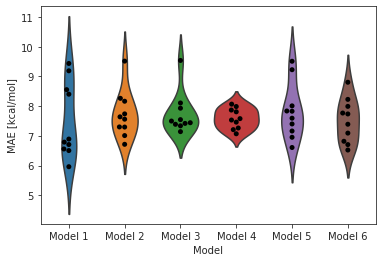

In [55]:
df_morgan = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_per_fold_morgan_se))],
    *['Model 2' for i in range(len(mae_per_fold_morgan))],
    *['Model 3' for i in range(len(mae_per_fold_morgan_se_nomordred))],
    *['Model 4' for i in range(len(mae_per_fold_morgan_nomordred))],
    *['Model 5' for i in range(len(mae_per_fold_morgan_se_noBDEs))],
    *['Model 6' for i in range(len(mae_per_fold_morgan_noBDEs))]
], 'MAE [kcal/mol]': [*mae_per_fold_morgan_se, *mae_per_fold_morgan, *mae_per_fold_morgan_se_nomordred, *mae_per_fold_morgan_nomordred, *mae_per_fold_morgan_se_noBDEs, *mae_per_fold_morgan_noBDEs]})

df_morgan.to_csv('cross_val_scores_morgan.csv')
plot_cross_val_scores(df_morgan)
plt.show()


In [50]:
df_morgan = pd.read_csv('cross_val_scores_morgan.csv', index_col=0)

In [52]:
new_scores = pd.DataFrame({'Model': [
    *['Model 7' for i in range(len(mae_per_fold_morgan_20best))],
    *['Model 8' for i in range(len(mae_per_fold_morgan_DeltaH))]
], 'MAE [kcal/mol]': [*mae_per_fold_morgan_20best, *mae_per_fold_morgan_DeltaH]})
df_morgan = pd.concat([df_morgan, new_scores])

In [56]:
df_morgan.to_csv('cross_val_scores_morgan.csv')

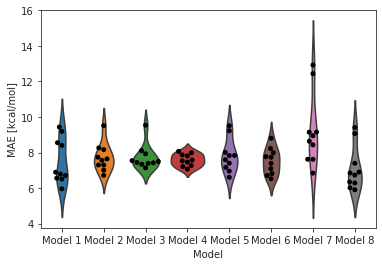

In [55]:
plot_cross_val_scores(df_morgan)
plt.show()

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
df_morgan = pd.read_csv('maes_per_fold/cross_val_scores_morgan.csv', index_col=0)

In [4]:
df_morgan.head()

,Model,MAE [kcal/mol]
0,Model 1,8.402096
1,Model 1,8.554863
2,Model 1,9.190003
3,Model 1,6.707117
4,Model 1,9.437047


In [5]:
names = [
    *['1' for i in range(10)],
    *['2' for i in range(10)],
    *['3' for i in range(10)],
    *['4' for i in range(10)],
    *['5' for i in range(10)],
    *['6' for i in range(10)],
    *['7' for i in range(10)],
    *['8' for i in range(10)],
]
df_morgan['Model'] = names

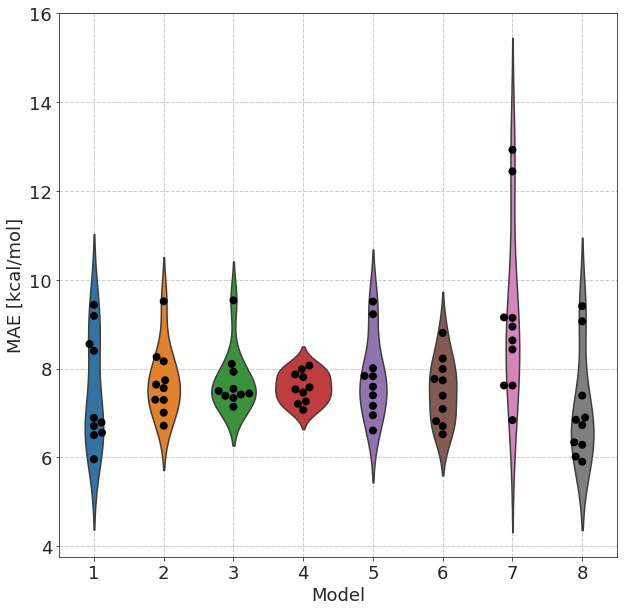

In [36]:
plot_cross_val_scores(df_morgan)
plt.savefig('overview_morgan.png', bbox_inches='tight')
plt.show()

In [6]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]})

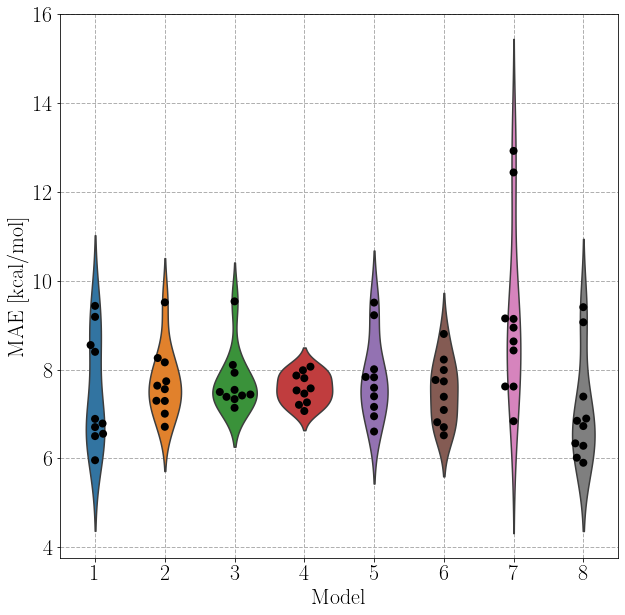

In [7]:
fs = 22
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.violinplot(x="Model", y="MAE [kcal/mol]", data=df_morgan, inner=None, orient='v')
ax = sns.swarmplot(x="Model", y="MAE [kcal/mol]", data=df_morgan, color='black', edgecolor='black', size=8)
ax.tick_params(labelsize = fs)
ax.set_ylabel('MAE [kcal/mol]', fontsize=fs)
ax.set_xlabel('Model', fontsize=fs)
ax.grid(linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.savefig('overview_morgan_report.pdf', bbox_inches='tight', dpi=600)
plt.show()

# SOAP (centred on H atom)

In [56]:
data_soap_se = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_H_start', 'soap_H_end'
]]

data_soap = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_H_start'
]]

data_soap_se_nomordred = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'soap_H_start', 'soap_H_end'
]]

data_soap_nomordred = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'soap_H_start'
]]

data_soap_se_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_H_start', 'soap_H_end'
]]

data_soap_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_H_start'
]]
data_soap_20best = data[[
    'Ea', 'translation', 'H_BDE', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H',
    'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H',
    'soap_H_start', 'soap_H_end'
]]
data_soap_DeltaH = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_H_start', 'soap_H_end'
]]
data_soap_DeltaH = data_soap_DeltaH.join(Delta_H_df)

In [57]:
data_soap_se_unpacked = unpack_join(data_soap_se, ['soap_H_start', 'soap_H_end'])
data_soap_se_unpacked = drop_zeros(data_soap_se_unpacked)

data_soap_unpacked = unpack_join(data_soap, ['soap_H_start'])
data_soap_unpacked = drop_zeros(data_soap_unpacked)

data_soap_se_nomordred_unpacked = unpack_join(data_soap_se_nomordred, ['soap_H_start', 'soap_H_end'])
data_soap_se_nomordred_unpacked = drop_zeros(data_soap_se_nomordred_unpacked)

data_soap_nomordred_unpacked = unpack_join(data_soap_nomordred, ['soap_H_start'])
data_soap_nomordred_unpacked = drop_zeros(data_soap_nomordred_unpacked)

data_soap_se_noBDEs_unpacked = unpack_join(data_soap_se_noBDEs, ['soap_H_start', 'soap_H_end'])
data_soap_se_noBDEs_unpacked = drop_zeros(data_soap_se_noBDEs_unpacked)

data_soap_noBDEs_unpacked = unpack_join(data_soap_noBDEs, ['soap_H_start'])
data_soap_noBDEs_unpacked = drop_zeros(data_soap_noBDEs_unpacked)

data_soap_20best = unpack_join(data_soap_20best, ['soap_H_start', 'soap_H_end'])
data_soap_20best = drop_zeros(data_soap_20best)

data_soap_DeltaH = unpack_join(data_soap_DeltaH, ['soap_H_start', 'soap_H_end'])
data_soap_DeltaH = drop_zeros(data_soap_DeltaH)

In [58]:
data_soap_se_unpacked.shape

(6150, 11508)

In [59]:
data_soap_unpacked.shape

(6150, 5768)

In [60]:
data_soap_se_nomordred_unpacked.shape

(6150, 11492)

In [61]:
data_soap_nomordred_unpacked.shape

(6150, 5752)

In [63]:
data_soap_se_noBDEs_unpacked.shape

(6150, 11506)

In [64]:
data_soap_noBDEs_unpacked.shape

(6150, 5766)

In [60]:
data_soap_20best.shape

(6150, 11501)

In [61]:
data_soap_DeltaH.shape

(6150, 11507)

In [3]:
def build_model_soap(input_shape):
    input = tf.keras.layers.Input(shape=(input_shape), dtype='float32')
    out = tf.keras.layers.Dense(128, activation='relu')(input)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dense(64, activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dense(1)(out)
    model = tf.keras.Model(input, out)
    return model

In [12]:
plot_nn(
    ['Input Layer', 'Hidden Layer', 'Batch Normalization', 'Hidden Layer', 'Batch Normalization', 'Output Layer'],
    [None, 128, None, 64, None, None],
    [None, 'ReLu', None, 'ReLu', None, None],
    file_name='NN_SOAP_LMBTR',
    title='NN for SOAP & LMBTR descriptors'
)

## Using SOAP descriptors of starting and end structures

In [66]:
targets = data_soap_se_unpacked.pop('Ea')
inputs = np.array(data_soap_se_unpacked)

In [67]:
model = build_model_soap(11507)

mae_per_fold_soap_se, loss_per_fold_soap_se = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 11.009989738464355; mae of 11.009989738464355
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 7.662392616271973; mae of 7.662392616271973
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 6.003528594970703; mae of 6.003528594970703
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 5.207821369171143; mae of 5.207821369171143
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 5.626880645751953; mae of 5.626880645751953
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 5.283178806304932; mae of 5.283178806304

## Using SOAP descriptors of starting structures

In [68]:
targets = data_soap_unpacked.pop('Ea')
inputs = np.array(data_soap_unpacked)

In [69]:
model = build_model_soap(5767)

mae_per_fold_soap, loss_per_fold_soap = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 8.820362091064453; mae of 8.820362091064453
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 8.586821556091309; mae of 8.586821556091309
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 7.127266883850098; mae of 7.127266883850098
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 6.763073921203613; mae of 6.763073921203613
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 6.127431869506836; mae of 6.127431869506836
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 6.003130912780762; mae of 6.00313091278076

## No Mordred descriptors

### Using SOAP descriptors of starting and end structures

In [70]:
targets = data_soap_se_nomordred_unpacked.pop('Ea')
inputs = np.array(data_soap_se_nomordred_unpacked)

In [71]:
model = build_model_soap(11491)

mae_per_fold_soap_se_nomordred, loss_per_fold_soap_se_nomordred = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 8.149430274963379; mae of 8.149430274963379
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 7.276899814605713; mae of 7.276899814605713
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 7.26105260848999; mae of 7.26105260848999
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 5.154054641723633; mae of 5.154054641723633
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 5.868691444396973; mae of 5.868691444396973
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 5.992353916168213; mae of 5.992353916168213


### Using SOAP descriptors of starting structures

In [72]:
targets = data_soap_nomordred_unpacked.pop('Ea')
inputs = np.array(data_soap_nomordred_unpacked)

In [73]:
model = build_model_soap(5751)

mae_per_fold_soap_nomordred, loss_per_fold_soap_nomordred = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 9.226123809814453; mae of 9.226123809814453
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 7.849157810211182; mae of 7.849157810211182
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 7.851034641265869; mae of 7.851034641265869
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 6.468608379364014; mae of 6.468608379364014
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 7.259655952453613; mae of 7.259655952453613
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 5.612753868103027; mae of 5.61275386810302

## No BDEs

### Using SOAP descriptors of starting and end structures

In [74]:
targets = data_soap_se_noBDEs_unpacked.pop('Ea')
inputs = np.array(data_soap_se_noBDEs_unpacked)

In [75]:
model = build_model_soap(11505)

mae_per_fold_soap_se_noBDEs, loss_per_fold_soap_se_noBDEs = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 7.806339740753174; mae of 7.806339740753174
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 7.34460973739624; mae of 7.34460973739624
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 6.407725811004639; mae of 6.407725811004639
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 5.711583614349365; mae of 5.711583614349365
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 5.342442512512207; mae of 5.342442512512207
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 4.832961082458496; mae of 4.832961082458496


### Using SOAP descriptors of starting structures

In [76]:
targets = data_soap_noBDEs_unpacked.pop('Ea')
inputs = np.array(data_soap_noBDEs_unpacked)

In [77]:
model = build_model_soap(5765)

mae_per_fold_soap_noBDEs, loss_per_fold_soap_noBDEs = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 8.615006446838379; mae of 8.615006446838379
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 8.440783500671387; mae of 8.440783500671387
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 7.401407718658447; mae of 7.401407718658447
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 6.605583667755127; mae of 6.605583667755127
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 6.2477803230285645; mae of 6.2477803230285645
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 6.897799968719482; mae of 6.897799968719

## Using only the 20 best descriptors

In [63]:
targets = data_soap_20best.pop('Ea')
inputs = np.array(data_soap_20best)

In [65]:
model = build_model_soap(11500)

mae_per_fold_soap_20best, loss_per_fold_soap_20best = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 8.663509368896484; mae of 8.663509368896484
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 10.542574882507324; mae of 10.542574882507324
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 6.681728839874268; mae of 6.681728839874268
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 5.521842956542969; mae of 5.521842956542969
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 6.0580902099609375; mae of 6.0580902099609375
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 5.76824951171875; mae of 5.76824951171

## Using the enthalpy of reaction as input

In [66]:
targets = data_soap_DeltaH.pop('Ea')
inputs = np.array(data_soap_DeltaH)

In [68]:
model = build_model_soap(11506)

mae_per_fold_soap_DeltaH, loss_per_fold_soap_DeltaH = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 7.770559310913086; mae of 7.770559310913086
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 6.797855377197266; mae of 6.797855377197266
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 7.045895099639893; mae of 7.045895099639893
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 5.596512794494629; mae of 5.596512794494629
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 5.60286808013916; mae of 5.60286808013916
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 4.926760196685791; mae of 4.926760196685791


## Comparison

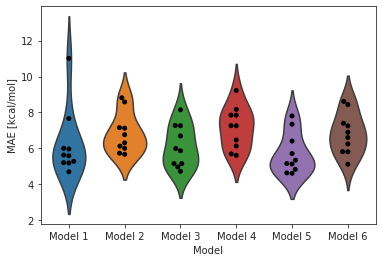

In [78]:
df_soap = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_per_fold_soap_se))],
    *['Model 2' for i in range(len(mae_per_fold_soap))],
    *['Model 3' for i in range(len(mae_per_fold_soap_se_nomordred))],
    *['Model 4' for i in range(len(mae_per_fold_soap_nomordred))],
    *['Model 5' for i in range(len(mae_per_fold_soap_se_noBDEs))],
    *['Model 6' for i in range(len(mae_per_fold_soap_noBDEs))]
], 'MAE [kcal/mol]': [*mae_per_fold_soap_se, *mae_per_fold_soap, *mae_per_fold_soap_se_nomordred, *mae_per_fold_soap_nomordred, *mae_per_fold_soap_se_noBDEs, *mae_per_fold_soap_noBDEs]})

df_soap.to_csv('cross_val_scores_soap.csv')

plot_cross_val_scores(df_soap)
plt.show()


In [69]:
df_soap = pd.read_csv('maes_per_fold/cross_val_scores_soap.csv', index_col=0)

In [70]:
new_scores = pd.DataFrame({'Model': [
    *['Model 7' for i in range(len(mae_per_fold_soap_20best))],
    *['Model 8' for i in range(len(mae_per_fold_soap_DeltaH))]
], 'MAE [kcal/mol]': [*mae_per_fold_soap_20best, *mae_per_fold_soap_DeltaH]})
df_soap = pd.concat([df_soap, new_scores])

In [72]:
df_soap.to_csv('cross_val_scores_soap.csv')

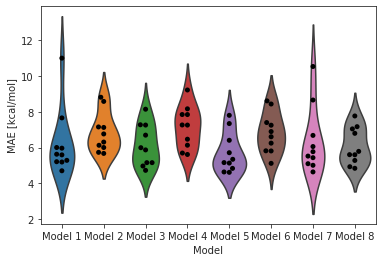

In [71]:
plot_cross_val_scores(df_soap)
plt.show()

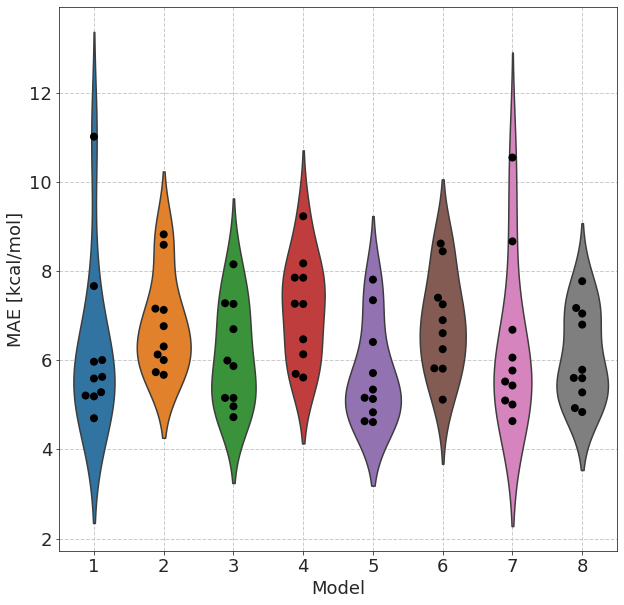

In [37]:
df_soap = pd.read_csv('cross_val_scores_soap.csv', index_col=0)
names = [
    *['1' for i in range(10)],
    *['2' for i in range(10)],
    *['3' for i in range(10)],
    *['4' for i in range(10)],
    *['5' for i in range(10)],
    *['6' for i in range(10)],
    *['7' for i in range(10)],
    *['8' for i in range(10)],
]
df_soap['Model'] = names
plot_cross_val_scores(df_soap)
plt.savefig('overview_soap.png', bbox_inches='tight')
plt.show()

In [9]:
df_soap = pd.read_csv('maes_per_fold/cross_val_scores_soap.csv', index_col=0)
names = [
    *['1' for i in range(10)],
    *['2' for i in range(10)],
    *['3' for i in range(10)],
    *['4' for i in range(10)],
    *['5' for i in range(10)],
    *['6' for i in range(10)],
    *['7' for i in range(10)],
    *['8' for i in range(10)],
]
df_soap['Model'] = names

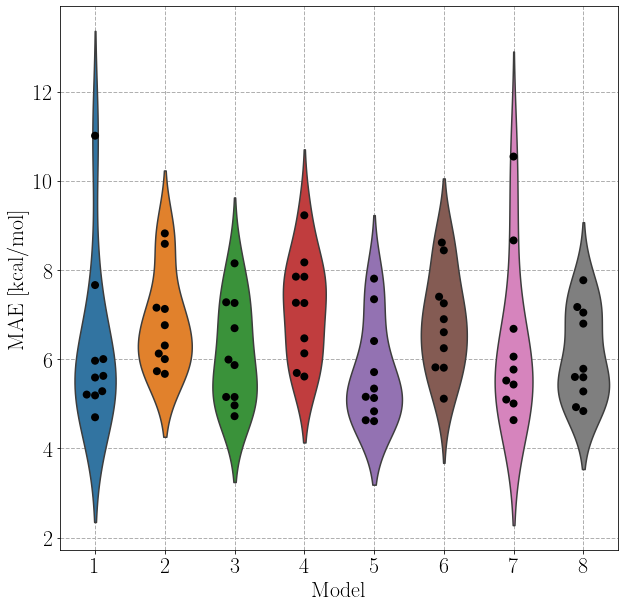

In [10]:
fs = 22
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.violinplot(x="Model", y="MAE [kcal/mol]", data=df_soap, inner=None, orient='v')
ax = sns.swarmplot(x="Model", y="MAE [kcal/mol]", data=df_soap, color='black', edgecolor='black', size=8)
ax.tick_params(labelsize = fs)
ax.set_ylabel('MAE [kcal/mol]', fontsize=fs)
ax.set_xlabel('Model', fontsize=fs)
ax.grid(linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.savefig('overview_soap_report.pdf', bbox_inches='tight', dpi=600)
plt.show()

# SOAP (centred on radical centres)

In [9]:
data_soap_centres_se = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_rad_start', 'soap_rad_end'
]]

data_soap_centres = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_rad_start'
]]

data_soap_centres_se_nomordred = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'soap_rad_start', 'soap_rad_end'
]]

data_soap_centres_nomordred = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'soap_rad_start'
]]

data_soap_centres_se_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_rad_start', 'soap_rad_end'
]]

data_soap_centres_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_rad_start'
]]
data_soap_centres_20best = data[[
    'Ea', 'translation', 'H_BDE', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H',
    'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H',
    'soap_rad_start', 'soap_rad_end'
]]
data_soap_centres_DeltaH = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_rad_start', 'soap_rad_end'
]]
data_soap_centres_DeltaH = data_soap_centres_DeltaH.join(Delta_H_df)

In [10]:
data_soap_centres_se_unpacked = unpack_join(data_soap_centres_se, ['soap_rad_start', 'soap_rad_end'])
data_soap_centres_se_unpacked = drop_zeros(data_soap_centres_se_unpacked)

data_soap_centres_unpacked = unpack_join(data_soap_centres, ['soap_rad_start'])
data_soap_centres_unpacked = drop_zeros(data_soap_centres_unpacked)

data_soap_centres_se_nomordred_unpacked = unpack_join(data_soap_centres_se_nomordred, ['soap_rad_start', 'soap_rad_end'])
data_soap_centres_se_nomordred_unpacked = drop_zeros(data_soap_centres_se_nomordred_unpacked)

data_soap_centres_nomordred_unpacked = unpack_join(data_soap_centres_nomordred, ['soap_rad_start'])
data_soap_centres_nomordred_unpacked = drop_zeros(data_soap_centres_nomordred_unpacked)

data_soap_centres_se_noBDEs_unpacked = unpack_join(data_soap_centres_se_noBDEs, ['soap_rad_start', 'soap_rad_end'])
data_soap_centres_se_noBDEs_unpacked = drop_zeros(data_soap_centres_se_noBDEs_unpacked)

data_soap_centres_noBDEs_unpacked = unpack_join(data_soap_centres_noBDEs, ['soap_rad_start'])
data_soap_centres_noBDEs_unpacked = drop_zeros(data_soap_centres_noBDEs_unpacked)

data_soap_centres_20best = unpack_join(data_soap_centres_20best, ['soap_rad_start', 'soap_rad_end'])
data_soap_centres_20best = drop_zeros(data_soap_centres_20best)

data_soap_centres_DeltaH = unpack_join(data_soap_centres_DeltaH, ['soap_rad_start', 'soap_rad_end'])
data_soap_centres_DeltaH = drop_zeros(data_soap_centres_DeltaH)

## Using SOAP descriptors of starting and end descriptors

In [11]:
data_soap_centres_se_unpacked.shape

(6150, 11508)

In [12]:
targets = data_soap_centres_se_unpacked.pop('Ea')
inputs = np.array(data_soap_centres_se_unpacked)
model = build_model_soap(11507)

mae_per_fold_soap_centres_se, loss_per_fold_soap_centres_se = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

2022-02-08 17:56:22.890184: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-08 17:56:22.890602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 17:56:22.891014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-02-08 17:56:22.891064: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libc

------------------------------------------------------------------------
Training for fold 1 ...


2022-02-08 17:56:29.704327: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 203811984 exceeds 10% of free system memory.
2022-02-08 17:56:30.079741: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-08 17:56:30.141495: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3192590000 Hz
2022-02-08 17:56:31.367234: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-08 17:56:36.129069: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 50952996 exceeds 10% of free system memory.
2022-02-08 17:57:05.288605: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 28307220 exceeds 10% of free system memory.


Score for fold 1: loss of 13.895302772521973; mae of 13.895302772521973
------------------------------------------------------------------------
Training for fold 2 ...


2022-02-08 17:57:06.318870: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 203811984 exceeds 10% of free system memory.
2022-02-08 17:57:08.219856: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 50952996 exceeds 10% of free system memory.


Score for fold 2: loss of 11.982648849487305; mae of 11.982648849487305
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 9.50939655303955; mae of 9.50939655303955
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 9.370485305786133; mae of 9.370485305786133
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 16.777315139770508; mae of 16.777315139770508
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 10.263076782226562; mae of 10.263076782226562
------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 7.269583702087402; mae of 7.269583702087402
------------------------------------------------------------------------
Training for fold 

## Using SOAP descriptors of starting structures

In [13]:
data_soap_centres_unpacked.shape

(6150, 5768)

In [14]:
targets = data_soap_centres_unpacked.pop('Ea')
inputs = np.array(data_soap_centres_unpacked)
model = build_model_soap(5767)

mae_per_fold_soap_centres, loss_per_fold_soap_centres = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 10.831706047058105; mae of 10.831706047058105
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 10.767585754394531; mae of 10.767585754394531
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 8.571094512939453; mae of 8.571094512939453
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 8.324454307556152; mae of 8.324454307556152
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 7.919897079467773; mae of 7.919897079467773
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 7.488412857055664; mae of 7.4884128570

## No Mordred descriptors
### Using SOAP descriptors of starting and end structures

In [15]:
data_soap_centres_se_nomordred_unpacked.shape

(6150, 11492)

In [16]:
targets = data_soap_centres_se_nomordred_unpacked.pop('Ea')
inputs = np.array(data_soap_centres_se_nomordred_unpacked)
model = build_model_soap(11491)

mae_per_fold_soap_centres_se_nomordred, loss_per_fold_soap_centres_se_nomordred = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 14.23387336730957; mae of 14.23387336730957
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 12.866015434265137; mae of 12.866015434265137
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 13.26412582397461; mae of 13.26412582397461
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 9.125593185424805; mae of 9.125593185424805
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 8.81351375579834; mae of 8.81351375579834
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 10.33927059173584; mae of 10.3392705917358

### Using SOAP descriptors of starting structures

In [17]:
data_soap_centres_nomordred_unpacked.shape

(6150, 5752)

In [22]:
targets = data_soap_centres_nomordred_unpacked.pop('Ea')
inputs = np.array(data_soap_centres_nomordred_unpacked)
model = build_model_soap(5751)

mae_per_fold_soap_centres_nomordred, loss_per_fold_soap_centres_nomordred = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 10.974993705749512; mae of 10.974993705749512
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 11.062333106994629; mae of 11.062333106994629
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 10.36520004272461; mae of 10.36520004272461
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 11.331316947937012; mae of 11.331316947937012
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 12.80505657196045; mae of 12.80505657196045
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 13.727716445922852; mae of 13.727716

## No BDEs
### Using SOAP descriptors of starting and end structures

In [18]:
data_soap_centres_se_noBDEs_unpacked.shape

(6150, 11506)

In [23]:
targets = data_soap_centres_se_noBDEs_unpacked.pop('Ea')
inputs = np.array(data_soap_centres_se_noBDEs_unpacked)
model = build_model_soap(11505)

mae_per_fold_soap_centres_se_noBDEs, loss_per_fold_soap_centres_se_noBDEs = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 14.842589378356934; mae of 14.842589378356934
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 13.26672649383545; mae of 13.26672649383545
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 9.633659362792969; mae of 9.633659362792969
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 10.875414848327637; mae of 10.875414848327637
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 9.985397338867188; mae of 9.985397338867188
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 9.940088272094727; mae of 9.9400882720

### Using SOAP descriptors of starting structures

In [19]:
data_soap_centres_noBDEs_unpacked.shape

(6150, 5766)

In [24]:
targets = data_soap_centres_noBDEs_unpacked.pop('Ea')
inputs = np.array(data_soap_centres_noBDEs_unpacked)
model = build_model_soap(5765)

mae_per_fold_soap_centres_noBDEs, loss_per_fold_soap_centres_noBDEs = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 11.465742111206055; mae of 11.465742111206055
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 9.663317680358887; mae of 9.663317680358887
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 11.341399192810059; mae of 11.341399192810059
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 9.501387596130371; mae of 9.501387596130371
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 8.924701690673828; mae of 8.924701690673828
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 10.15025520324707; mae of 10.150255203

## Using only the 20 best descriptors

In [20]:
data_soap_centres_20best.shape

(6150, 11501)

In [25]:
targets = data_soap_centres_20best.pop('Ea')
inputs = np.array(data_soap_centres_20best)
model = build_model_soap(11500)

mae_per_fold_soap_centres_20best, loss_per_fold_soap_centres_20best = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 14.343950271606445; mae of 14.343950271606445
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 11.314123153686523; mae of 11.314123153686523
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 22.936458587646484; mae of 22.936458587646484
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 12.799262046813965; mae of 12.799262046813965
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 9.167601585388184; mae of 9.167601585388184
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 12.255927085876465; mae of 12.2559

## Using the enthalpy of reaction as a direct input

In [21]:
data_soap_centres_DeltaH.shape

(6150, 11507)

In [26]:
targets = data_soap_centres_DeltaH.pop('Ea')
inputs = np.array(data_soap_centres_DeltaH)
model = build_model_soap(11506)

mae_per_fold_soap_centres_DeltaH, loss_per_fold_soap_centres_DeltaH = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 13.617569923400879; mae of 13.617569923400879
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 10.982120513916016; mae of 10.982120513916016
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 10.588722229003906; mae of 10.588722229003906
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 8.795473098754883; mae of 8.795473098754883
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 8.762643814086914; mae of 8.762643814086914
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 9.71359920501709; mae of 9.713599205

## Comparison

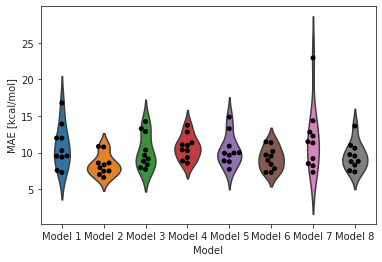

In [27]:
df_soap_centres = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_per_fold_soap_centres_se))],
    *['Model 2' for i in range(len(mae_per_fold_soap_centres))],
    *['Model 3' for i in range(len(mae_per_fold_soap_centres_se_nomordred))],
    *['Model 4' for i in range(len(mae_per_fold_soap_centres_nomordred))],
    *['Model 5' for i in range(len(mae_per_fold_soap_centres_se_noBDEs))],
    *['Model 6' for i in range(len(mae_per_fold_soap_centres_noBDEs))],
    *['Model 7' for i in range(len(mae_per_fold_soap_centres_20best))],
    *['Model 8' for i in range(len(mae_per_fold_soap_centres_DeltaH))]
], 'MAE [kcal/mol]': [
    *mae_per_fold_soap_centres_se, *mae_per_fold_soap_centres, *mae_per_fold_soap_centres_se_nomordred,
    *mae_per_fold_soap_centres_nomordred, *mae_per_fold_soap_centres_se_noBDEs, *mae_per_fold_soap_centres_noBDEs,
    *mae_per_fold_soap_centres_20best, *mae_per_fold_soap_centres_DeltaH
]})

df_soap_centres.to_csv('cross_val_scores_soap_centres.csv')

plot_cross_val_scores(df_soap_centres)
plt.show()

# LMBTR (centred on H atom)

In [79]:
data_lmbtr_se = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_H_start', 'lmbtr_H_end'
]]

data_lmbtr = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_H_start'
]]

data_lmbtr_se_nomordred = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'lmbtr_H_start', 'lmbtr_H_end'
]]

data_lmbtr_nomordred = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'lmbtr_H_start'
]]

data_lmbtr_se_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_H_start', 'lmbtr_H_end'
]]

data_lmbtr_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_H_start'
]]

In [73]:
data_lmbtr_20best = data[[
    'Ea', 'translation', 'H_BDE', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H',
    'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H',
    'lmbtr_H_start', 'lmbtr_H_end'
]]
data_lmbtr_DeltaH = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_H_start', 'lmbtr_H_end'
]]
data_lmbtr_DeltaH = data_lmbtr_DeltaH.join(Delta_H_df)

In [80]:
data_lmbtr_se_unpacked = unpack_join(data_lmbtr_se, ['lmbtr_H_start', 'lmbtr_H_end'])
data_lmbtr_se_unpacked = drop_zeros(data_lmbtr_se_unpacked)

data_lmbtr_unpacked = unpack_join(data_lmbtr, ['lmbtr_H_start'])
data_lmbtr_unpacked = drop_zeros(data_lmbtr_unpacked)

data_lmbtr_se_nomordred_unpacked = unpack_join(data_lmbtr_se_nomordred, ['lmbtr_H_start', 'lmbtr_H_end'])
data_lmbtr_se_nomordred_unpacked = drop_zeros(data_lmbtr_se_nomordred_unpacked)

data_lmbtr_nomordred_unpacked = unpack_join(data_lmbtr_nomordred, ['lmbtr_H_start'])
data_lmbtr_nomordred_unpacked = drop_zeros(data_lmbtr_nomordred_unpacked)

data_lmbtr_se_noBDEs_unpacked = unpack_join(data_lmbtr_se_noBDEs, ['lmbtr_H_start', 'lmbtr_H_end'])
data_lmbtr_se_noBDEs_unpacked = drop_zeros(data_lmbtr_se_noBDEs_unpacked)

data_lmbtr_noBDEs_unpacked = unpack_join(data_lmbtr_noBDEs, ['lmbtr_H_start'])
data_lmbtr_noBDEs_unpacked = drop_zeros(data_lmbtr_noBDEs_unpacked)

In [74]:
data_lmbtr_20best = unpack_join(data_lmbtr_20best, ['lmbtr_H_start', 'lmbtr_H_end'])
data_lmbtr_20best = drop_zeros(data_lmbtr_20best)

data_lmbtr_DeltaH = unpack_join(data_lmbtr_DeltaH, ['lmbtr_H_start', 'lmbtr_H_end'])
data_lmbtr_DeltaH = drop_zeros(data_lmbtr_DeltaH)

In [81]:
data_lmbtr_se_unpacked.shape

(6150, 8242)

In [82]:
data_lmbtr_unpacked.shape

(6150, 4135)

In [83]:
data_lmbtr_se_nomordred_unpacked.shape

(6150, 8226)

In [84]:
data_lmbtr_nomordred_unpacked.shape

(6150, 4119)

In [85]:
data_lmbtr_se_noBDEs_unpacked.shape

(6150, 8240)

In [86]:
data_lmbtr_noBDEs_unpacked.shape

(6150, 4133)

In [75]:
data_lmbtr_20best.shape

(6150, 8235)

In [76]:
data_lmbtr_DeltaH.shape

(6150, 8241)

## Using LMBTR descriptors of starting and end structures

In [87]:
targets = data_lmbtr_se_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_se_unpacked)

In [89]:
model = build_model_soap(8241)

mae_per_fold_lmbtr_se, loss_per_fold_lmbtr_se = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 26.974714279174805; mae of 26.974714279174805
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 9.115619659423828; mae of 9.115619659423828
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 19.630428314208984; mae of 19.630428314208984
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 18.088834762573242; mae of 18.088834762573242
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 10.411334991455078; mae of 10.411334991455078
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 7.302187442779541; mae of 7.302187

## Using LMBTR descriptors of starting structures

In [90]:
targets = data_lmbtr_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_unpacked)

In [91]:
model = build_model_soap(4134)

mae_per_fold_lmbtr, loss_per_fold_lmbtr = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 29.854928970336914; mae of 29.854928970336914
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 15.471729278564453; mae of 15.471729278564453
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 12.281012535095215; mae of 12.281012535095215
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 18.650230407714844; mae of 18.650230407714844
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 23.88926887512207; mae of 23.88926887512207
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 6.316457748413086; mae of 6.316457

## No Mordred descriptors

### Using LMBTR descriptors of starting and end structures

In [92]:
targets = data_lmbtr_se_nomordred_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_se_nomordred_unpacked)

In [93]:
model = build_model_soap(8225)

mae_per_fold_lmbtr_se_nomordred, loss_per_fold_lmbtr_se_nomordred = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 15.821855545043945; mae of 15.821855545043945
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 22.269325256347656; mae of 22.269325256347656
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 10.342820167541504; mae of 10.342820167541504
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 20.496965408325195; mae of 20.496965408325195
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 21.44472885131836; mae of 21.44472885131836
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 8.970947265625; mae of 8.970947265

### Using LMBTR descriptors of starting structures

In [94]:
targets = data_lmbtr_nomordred_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_nomordred_unpacked)

In [95]:
model = build_model_soap(4118)

mae_per_fold_lmbtr_nomordred, loss_per_fold_lmbtr_nomordred = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 11.854717254638672; mae of 11.854717254638672
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 26.068403244018555; mae of 26.068403244018555
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 18.089059829711914; mae of 18.089059829711914
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 6.11686897277832; mae of 6.11686897277832
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 34.6112060546875; mae of 34.6112060546875
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 8.48277473449707; mae of 8.4827747344970

## No BDEs

### Using LMBTR descriptors of starting and end structures

In [96]:
targets = data_lmbtr_se_noBDEs_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_se_noBDEs_unpacked)

In [97]:
model = build_model_soap(8239)

mae_per_fold_lmbtr_se_noBDEs, loss_per_fold_lmbtr_se_noBDEs = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 6.840382099151611; mae of 6.840382099151611
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 5.9003682136535645; mae of 5.9003682136535645
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 6.148275852203369; mae of 6.148275852203369
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 4.955351829528809; mae of 4.955351829528809
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 8.436966896057129; mae of 8.436966896057129
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 4.8110833168029785; mae of 4.81108331680

### Using LMBTR descriptors of starting structures

In [98]:
targets = data_lmbtr_noBDEs_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_noBDEs_unpacked)

In [99]:
model = build_model_soap(4132)

mae_per_fold_lmbtr_noBDEs, loss_per_fold_lmbtr_noBDEs = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 7.833350658416748; mae of 7.833350658416748
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 7.0036211013793945; mae of 7.0036211013793945
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 6.123632907867432; mae of 6.123632907867432
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 6.186437606811523; mae of 6.186437606811523
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 5.775691032409668; mae of 5.775691032409668
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 4.880343914031982; mae of 4.880343914031

## Using only the 20 best descriptors

In [77]:
targets = data_lmbtr_20best.pop('Ea')
inputs = np.array(data_lmbtr_20best)

In [79]:
model = build_model_soap(8234)

mae_per_fold_lmbtr_20best, loss_per_fold_lmbtr_20best = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 14.006800651550293; mae of 14.006800651550293
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 8.924468994140625; mae of 8.924468994140625
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 9.50086784362793; mae of 9.50086784362793
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 7.1529130935668945; mae of 7.1529130935668945
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 7.769474029541016; mae of 7.769474029541016
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 8.420684814453125; mae of 8.420684814453

## Using the enthalpy of reaction as input

In [80]:
targets = data_lmbtr_DeltaH.pop('Ea')
inputs = np.array(data_lmbtr_DeltaH)

In [82]:
model = build_model_soap(8240)

mae_per_fold_lmbtr_DeltaH, loss_per_fold_lmbtr_DeltaH = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 8.680198669433594; mae of 8.680198669433594
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 5.652295112609863; mae of 5.652295112609863
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 5.5261406898498535; mae of 5.5261406898498535
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 4.90325927734375; mae of 4.90325927734375
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 4.825896263122559; mae of 4.825896263122559
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 6.177417278289795; mae of 6.17741727828979

## Comparison

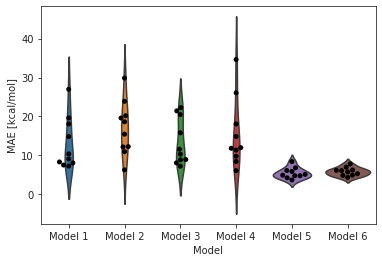

In [101]:
df_lmbtr = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_per_fold_lmbtr_se))],
    *['Model 2' for i in range(len(mae_per_fold_lmbtr))],
    *['Model 3' for i in range(len(mae_per_fold_lmbtr_se_nomordred))],
    *['Model 4' for i in range(len(mae_per_fold_lmbtr_nomordred))],
    *['Model 5' for i in range(len(mae_per_fold_lmbtr_se_noBDEs))],
    *['Model 6' for i in range(len(mae_per_fold_lmbtr_noBDEs))]
], 'MAE [kcal/mol]': [*mae_per_fold_lmbtr_se, *mae_per_fold_lmbtr, *mae_per_fold_lmbtr_se_nomordred, *mae_per_fold_lmbtr_nomordred, *mae_per_fold_lmbtr_se_noBDEs, *mae_per_fold_lmbtr_noBDEs]})

df_lmbtr.to_csv('cross_val_scores_lmbtr.csv')

plot_cross_val_scores(df_lmbtr)
plt.show()

In [83]:
df_lmbtr = pd.read_csv('cross_val_scores_lmbtr.csv', index_col=0)

In [84]:
new_scores = pd.DataFrame({'Model': [
    *['Model 7' for i in range(len(mae_per_fold_lmbtr_20best))],
    *['Model 8' for i in range(len(mae_per_fold_lmbtr_DeltaH))]
], 'MAE [kcal/mol]': [*mae_per_fold_lmbtr_20best, *mae_per_fold_lmbtr_DeltaH]})
df_lmbtr = pd.concat([df_lmbtr, new_scores])

In [86]:
df_lmbtr.to_csv('cross_val_scores_lmbtr.csv')

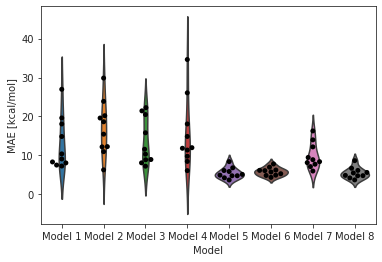

In [85]:
plot_cross_val_scores(df_lmbtr)
plt.show()

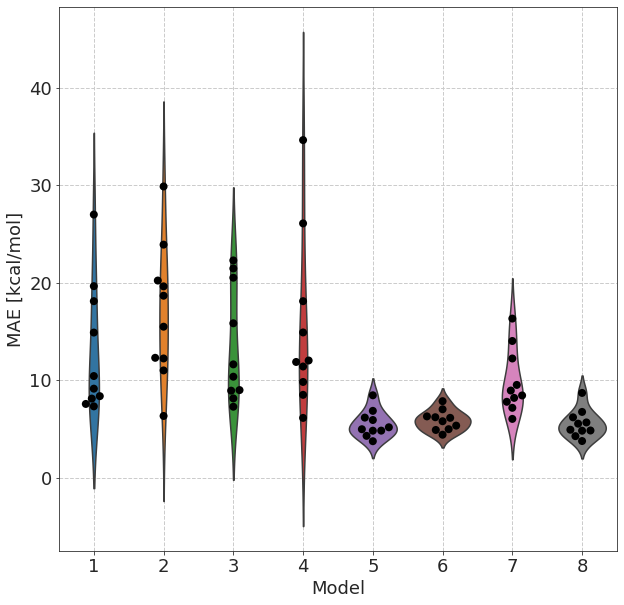

In [38]:
df_lmbtr = pd.read_csv('cross_val_scores_lmbtr.csv', index_col=0)
names = [
    *['1' for i in range(10)],
    *['2' for i in range(10)],
    *['3' for i in range(10)],
    *['4' for i in range(10)],
    *['5' for i in range(10)],
    *['6' for i in range(10)],
    *['7' for i in range(10)],
    *['8' for i in range(10)],
]
df_lmbtr['Model'] = names
plot_cross_val_scores(df_lmbtr)
plt.savefig('overview_lmbtr.png', bbox_inches='tight')
plt.show()

In [11]:
df_lmbtr = pd.read_csv('maes_per_fold/cross_val_scores_lmbtr.csv', index_col=0)
names = [
    *['1' for i in range(10)],
    *['2' for i in range(10)],
    *['3' for i in range(10)],
    *['4' for i in range(10)],
    *['5' for i in range(10)],
    *['6' for i in range(10)],
    *['7' for i in range(10)],
    *['8' for i in range(10)],
]
df_lmbtr['Model'] = names

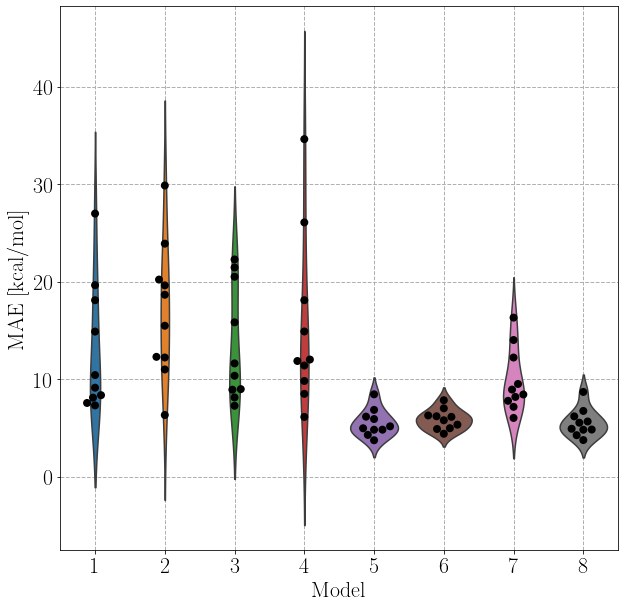

In [12]:
fs = 22
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.violinplot(x="Model", y="MAE [kcal/mol]", data=df_lmbtr, inner=None, orient='v')
ax = sns.swarmplot(x="Model", y="MAE [kcal/mol]", data=df_lmbtr, color='black', edgecolor='black', size=8)
ax.tick_params(labelsize = fs)
ax.set_ylabel('MAE [kcal/mol]', fontsize=fs)
ax.set_xlabel('Model', fontsize=fs)
ax.grid(linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.savefig('overview_lmbtr_report.pdf', bbox_inches='tight', dpi=600)
plt.show()

# LMBTR (centred on radical centres)

In [10]:
data_lmbtr_centres_se = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_rad_start', 'lmbtr_rad_end'
]]

data_lmbtr_centres = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_rad_start'
]]

data_lmbtr_centres_se_nomordred = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'lmbtr_rad_start', 'lmbtr_rad_end'
]]

data_lmbtr_centres_nomordred = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'lmbtr_rad_start'
]]

data_lmbtr_centres_se_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_rad_start', 'lmbtr_rad_end'
]]

data_lmbtr_centres_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_rad_start'
]]
data_lmbtr_centres_20best = data[[
    'Ea', 'translation', 'H_BDE', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H',
    'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H',
    'lmbtr_rad_start', 'lmbtr_rad_end'
]]
data_lmbtr_centres_DeltaH = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_rad_start', 'lmbtr_rad_end'
]]
data_lmbtr_centres_DeltaH = data_lmbtr_centres_DeltaH.join(Delta_H_df)

In [11]:
data_lmbtr_centres_se_unpacked = unpack_join(data_lmbtr_centres_se, ['lmbtr_rad_start', 'lmbtr_rad_end'])
data_lmbtr_centres_se_unpacked = drop_zeros(data_lmbtr_centres_se_unpacked)

data_lmbtr_centres_unpacked = unpack_join(data_lmbtr_centres, ['lmbtr_rad_start'])
data_lmbtr_centres_unpacked = drop_zeros(data_lmbtr_centres_unpacked)

data_lmbtr_centres_se_nomordred_unpacked = unpack_join(data_lmbtr_centres_se_nomordred, ['lmbtr_rad_start', 'lmbtr_rad_end'])
data_lmbtr_centres_se_nomordred_unpacked = drop_zeros(data_lmbtr_centres_se_nomordred_unpacked)

data_lmbtr_centres_nomordred_unpacked = unpack_join(data_lmbtr_centres_nomordred, ['lmbtr_rad_start'])
data_lmbtr_centres_nomordred_unpacked = drop_zeros(data_lmbtr_centres_nomordred_unpacked)

data_lmbtr_centres_se_noBDEs_unpacked = unpack_join(data_lmbtr_centres_se_noBDEs, ['lmbtr_rad_start', 'lmbtr_rad_end'])
data_lmbtr_centres_se_noBDEs_unpacked = drop_zeros(data_lmbtr_centres_se_noBDEs_unpacked)

data_lmbtr_centres_noBDEs_unpacked = unpack_join(data_lmbtr_centres_noBDEs, ['lmbtr_rad_start'])
data_lmbtr_centres_noBDEs_unpacked = drop_zeros(data_lmbtr_centres_noBDEs_unpacked)

data_lmbtr_centres_20best = unpack_join(data_lmbtr_centres_20best, ['lmbtr_rad_start', 'lmbtr_rad_end'])
data_lmbtr_centres_20best = drop_zeros(data_lmbtr_centres_20best)

data_lmbtr_centres_DeltaH = unpack_join(data_lmbtr_centres_DeltaH, ['lmbtr_rad_start', 'lmbtr_rad_end'])
data_lmbtr_centres_DeltaH = drop_zeros(data_lmbtr_centres_DeltaH)

## Using LMBTR descriptors of starting and end structures

In [12]:
data_lmbtr_centres_se_unpacked.shape

(6150, 8066)

In [13]:
targets = data_lmbtr_centres_se_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_centres_se_unpacked)
model = build_model_soap(8065)

mae_per_fold_lmbtr_centres_se, loss_per_fold_lmbtr_centres_se = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

2022-02-08 19:42:32.035864: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-08 19:42:32.046102: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-08 19:42:32.121442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 19:42:32.122983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-02-08 19:42:32.123019: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-08 19:42:32.294002: I tensorflow/stream_executor/platform/def

------------------------------------------------------------------------
Training for fold 1 ...


2022-02-08 19:42:36.773750: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 142847280 exceeds 10% of free system memory.
2022-02-08 19:42:37.131170: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-08 19:42:37.173491: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3192590000 Hz
2022-02-08 19:42:38.283217: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-08 19:42:41.068574: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 35711820 exceeds 10% of free system memory.


Score for fold 1: loss of 8.570425033569336; mae of 8.570425033569336
------------------------------------------------------------------------
Training for fold 2 ...


2022-02-08 19:43:12.054074: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 142847280 exceeds 10% of free system memory.
2022-02-08 19:43:15.563253: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 35711820 exceeds 10% of free system memory.
2022-02-08 19:43:45.520958: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19839900 exceeds 10% of free system memory.


Score for fold 2: loss of 20.477941513061523; mae of 20.477941513061523
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 15.083484649658203; mae of 15.083484649658203
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 17.483030319213867; mae of 17.483030319213867
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 11.136399269104004; mae of 11.136399269104004
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 13.714162826538086; mae of 13.714162826538086
------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss of 12.9944429397583; mae of 12.9944429397583
------------------------------------------------------------------------
Training for f

In [14]:
np.save('mae_per_fold_lmbtr_centres_se', mae_per_fold_lmbtr_centres_se)

## Using LMBTR descriptors of starting structures

In [15]:
data_lmbtr_centres_unpacked.shape

(6150, 4047)

In [16]:
targets = data_lmbtr_centres_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_centres_unpacked)
model = build_model_soap(4046)

mae_per_fold_lmbtr_centres, loss_per_fold_lmbtr_centres = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 11.079008102416992; mae of 11.079008102416992
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 11.193882942199707; mae of 11.193882942199707
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 10.507218360900879; mae of 10.507218360900879
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 11.482301712036133; mae of 11.482301712036133
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 11.152467727661133; mae of 11.152467727661133
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 10.515721321105957; mae of 10.51

In [17]:
np.save('mae_per_fold_lmbtr_centres', mae_per_fold_lmbtr_centres)

## No Mordred descriptors
### Using LMBTR descriptors of starting and end structures

In [18]:
data_lmbtr_centres_se_nomordred_unpacked.shape

(6150, 8050)

In [19]:
targets = data_lmbtr_centres_se_nomordred_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_centres_se_nomordred_unpacked)
model = build_model_soap(8049)

mae_per_fold_lmbtr_centres_se_nomordred, loss_per_fold_lmbtr_centres_se_nomordred = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 12.67859935760498; mae of 12.67859935760498
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 21.896831512451172; mae of 21.896831512451172
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 13.617338180541992; mae of 13.617338180541992
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 20.3504695892334; mae of 20.3504695892334
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 21.83271026611328; mae of 21.83271026611328
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 15.101471900939941; mae of 15.1014719009

In [20]:
np.save('mae_per_fold_lmbtr_centres_se_nomordred', mae_per_fold_lmbtr_centres_se_nomordred)

### Using LMBTR descriptors of starting structures

In [21]:
data_lmbtr_centres_nomordred_unpacked.shape

(6150, 4031)

In [22]:
targets = data_lmbtr_centres_nomordred_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_centres_nomordred_unpacked)
model = build_model_soap(4030)

mae_per_fold_lmbtr_centres_nomordred, loss_per_fold_lmbtr_centres_nomordred = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 9.550222396850586; mae of 9.550222396850586
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 31.226871490478516; mae of 31.226871490478516
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 13.048474311828613; mae of 13.048474311828613
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 14.123342514038086; mae of 14.123342514038086
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 11.533170700073242; mae of 11.533170700073242
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 8.860572814941406; mae of 8.860572

In [23]:
np.save('mae_per_fold_lmbtr_centres_nomordred', mae_per_fold_lmbtr_centres_nomordred)

## No BDEs
### Using LMBTR descriptors of starting and end structures

In [24]:
data_lmbtr_centres_se_noBDEs_unpacked.shape

(6150, 8064)

In [25]:
targets = data_lmbtr_centres_se_noBDEs_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_centres_se_noBDEs_unpacked)
model = build_model_soap(8063)

mae_per_fold_lmbtr_centres_se_noBDEs, loss_per_fold_lmbtr_centres_se_noBDEs = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 7.479264259338379; mae of 7.479264259338379
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 7.277116775512695; mae of 7.277116775512695
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 7.935304641723633; mae of 7.935304641723633
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 6.818673610687256; mae of 6.818673610687256
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 7.736021518707275; mae of 7.736021518707275
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 4.996006011962891; mae of 4.99600601196289

In [26]:
np.save('mae_per_fold_lmbtr_centres_se_noBDEs', mae_per_fold_lmbtr_centres_se_noBDEs)

### Using LMBTR descriptors of starting structures

In [27]:
data_lmbtr_centres_noBDEs_unpacked.shape

(6150, 4045)

In [28]:
targets = data_lmbtr_centres_noBDEs_unpacked.pop('Ea')
inputs = np.array(data_lmbtr_centres_noBDEs_unpacked)
model = build_model_soap(4044)

mae_per_fold_lmbtr_centres_noBDEs, loss_per_fold_lmbtr_centres_noBDEs = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 9.32393741607666; mae of 9.32393741607666
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 8.679969787597656; mae of 8.679969787597656
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 6.78003454208374; mae of 6.78003454208374
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 6.939223766326904; mae of 6.939223766326904
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 5.815925121307373; mae of 5.815925121307373
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 7.987400531768799; mae of 7.987400531768799
--

In [29]:
np.save('mae_per_fold_lmbtr_centres_noBDEs', mae_per_fold_lmbtr_centres_noBDEs)

## Using only the 20 best descriptors

In [30]:
data_lmbtr_centres_20best.shape

(6150, 8059)

In [31]:
targets = data_lmbtr_centres_20best.pop('Ea')
inputs = np.array(data_lmbtr_centres_20best)
model = build_model_soap(8058)

mae_per_fold_lmbtr_centres_20best, loss_per_fold_lmbtr_centres_20best = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 8.75348949432373; mae of 8.75348949432373
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 18.492021560668945; mae of 18.492021560668945
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 12.819365501403809; mae of 12.819365501403809
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 7.704096794128418; mae of 7.704096794128418
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 7.908204555511475; mae of 7.908204555511475
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 17.083534240722656; mae of 17.0835342407

In [32]:
np.save('mae_per_fold_lmbtr_centres_20best', mae_per_fold_lmbtr_centres_20best)

## Using the enthalpy of reaction as a direct input

In [33]:
data_lmbtr_centres_DeltaH.shape

(6150, 8065)

In [34]:
targets = data_lmbtr_centres_DeltaH.pop('Ea')
inputs = np.array(data_lmbtr_centres_DeltaH)
model = build_model_soap(8064)

mae_per_fold_lmbtr_centres_DeltaH, loss_per_fold_lmbtr_centres_DeltaH = K_fold_cross_validation(inputs, targets, 10, model, mixed_dtypes=False, loss='mae', no_epochs=30, batch_size=32)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 7.876371383666992; mae of 7.876371383666992
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 6.902602672576904; mae of 6.902602672576904
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 7.204586505889893; mae of 7.204586505889893
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 6.011851787567139; mae of 6.011851787567139
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 5.147175312042236; mae of 5.147175312042236
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 4.976181983947754; mae of 4.97618198394775

In [35]:
np.save('mae_per_fold_lmbtr_centres_DeltaH', mae_per_fold_lmbtr_centres_DeltaH)

## Comparison

In [ ]:
mae_per_fold_lmbtr_centres_se = np.load('mae_per_fold_lmbtr_centres_se')
mae_per_fold_lmbtr_centres = np.load('mae_per_fold_lmbtr_centres')
mae_per_fold_lmbtr_centres_se_nomordred = np.load('mae_per_fold_lmbtr_centres_se_nomordred')
mae_per_fold_lmbtr_centres_nomordred = np.load('mae_per_fold_lmbtr_centres_nomordred')
mae_per_fold_lmbtr_centres_se_noBDEs = np.load('mae_per_fold_lmbtr_centres_se_noBDEs')
mae_per_fold_lmbtr_centres_noBDEs = np.load('mae_per_fold_lmbtr_centres_noBDEs')
mae_per_fold_lmbtr_centres_20best = np.load('mae_per_fold_lmbtr_centres_20best')
mae_per_fold_lmbtr_centres_DeltaH = np.load('mae_per_fold_lmbtr_centres_DeltaH')

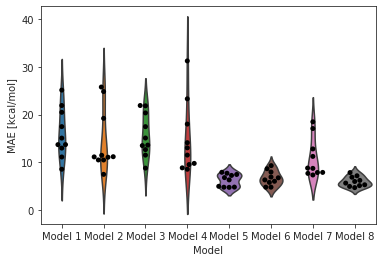

In [37]:
df_lmbtr_centres = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_per_fold_lmbtr_centres_se))],
    *['Model 2' for i in range(len(mae_per_fold_lmbtr_centres))],
    *['Model 3' for i in range(len(mae_per_fold_lmbtr_centres_se_nomordred))],
    *['Model 4' for i in range(len(mae_per_fold_lmbtr_centres_nomordred))],
    *['Model 5' for i in range(len(mae_per_fold_lmbtr_centres_se_noBDEs))],
    *['Model 6' for i in range(len(mae_per_fold_lmbtr_centres_noBDEs))],
    *['Model 7' for i in range(len(mae_per_fold_lmbtr_centres_20best))],
    *['Model 8' for i in range(len(mae_per_fold_lmbtr_centres_DeltaH))]
], 'MAE [kcal/mol]': [
    *mae_per_fold_lmbtr_centres_se, *mae_per_fold_lmbtr_centres, *mae_per_fold_lmbtr_centres_se_nomordred,
    *mae_per_fold_lmbtr_centres_nomordred, *mae_per_fold_lmbtr_centres_se_noBDEs, *mae_per_fold_lmbtr_centres_noBDEs,
    *mae_per_fold_lmbtr_centres_20best, *mae_per_fold_lmbtr_centres_DeltaH
]})

df_lmbtr_centres.to_csv('cross_val_scores_lmbtr_centres.csv')

plot_cross_val_scores(df_lmbtr_centres)
plt.show()

# One-hot encode reference compounds

## Including BDEs

In [4]:
data_onehot = data[[
    'translation', 'Ea', 'rad_ref_comp', 'H_ref_comp',
    'rad_BDE', 'H_BDE', 'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_H', 'SpMax_A_H', 'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H',
    'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H'
]]
targets = data_onehot.pop('Ea')

In [5]:
inputs = {}

for name, column in data_onehot.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

In [6]:
# concatenate numeric inputs together and run them through a normalization layer
numeric_inputs = {name:input for name,input in inputs.items() if input.dtype==tf.float32}

# requires newer tensorflow version than the one with GPU support
x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = tf.keras.layers.Normalization()
norm.adapt(np.array(data_onehot[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)
preprocessed_inputs = [all_numeric_inputs]

2022-02-01 02:05:55.265907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 02:05:55.266509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hits/fast/mbm/software/gaussian/g09d1/g09:/hits/fast/mbm/software/gaussian/g09d1/g09:/hits/fast/mbm/software/gaussian/g09d1/g09:
2022-02-01 02:05:55.268487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hits/fast/mbm/software/gaussian/g09d1/g09:/hits/fast/mbm/software/gaussian/g09d1/g09:/hits/fast/mbm/software/gaussian/g09d1/g09:
2022-02-01 02:05:55.269331: 

In [7]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = tf.keras.layers.StringLookup(vocabulary=np.unique(data_onehot[name])) # map from strings to intiger indices
  one_hot = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size()) # convert indices into float32 data, the default setting is to create a one-hot vector for each input 

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

In [8]:
preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)

preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

In [9]:
# build the model on top of the preprocessing
def onehot_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)
  return model

In [31]:
dot = Digraph(
    node_attr={'shape': 'box', 'fillcolor': 'lightblue2', 'style': 'filled'},
)
dot.attr(label='NN architecture')

dot.node('I', 'Input Layer')
dot.node('O', 'One-hot encode\nreference compounds')
dot.node('N', 'Normalize numerical\ninputs')
dot.node('H1', 'Hidden Layer\n64 nodes\nActivation: ReLu')
dot.node('H2', 'Hidden Layer\n32 nodes\nActivation: ReLu')
dot.node('Out', 'Output Layer')

dot.edges(['IO', 'IN'])
dot.edge('O', 'H1')
dot.edge('N', 'H1')
dot.edge('H1', 'H2')
dot.edge('H2', 'Out')

dot.format = 'png'
dot.render('NN_onehot')

'NN_onehot.png'

In [10]:
model = onehot_model(preprocessing, inputs)
mae_per_fold_onehot, loss_per_fold_onehot = K_fold_cross_validation(data_onehot, np.array(targets), 10, model, True, loss='mae', batch_size=100)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 7.608704090118408; mae of 7.608704090118408
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 7.750476360321045; mae of 7.750476360321045
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 7.263499736785889; mae of 7.263499736785889
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 6.3048882484436035; mae of 6.3048882484436035
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 6.399714946746826; mae of 6.399714946746826
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 6.443662166595459; mae of 6.443662166595

## No BDEs

In [11]:
data_onehot_noBDEs = data[[
    'translation', 'Ea', 'rad_ref_comp', 'H_ref_comp',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_H', 'SpMax_A_H', 'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H',
    'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H'
]]
targets = data_onehot_noBDEs.pop('Ea')

In [12]:
inputs = {}

for name, column in data_onehot_noBDEs.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

In [13]:
# concatenate numeric inputs together and run them through a normalization layer
numeric_inputs = {name:input for name,input in inputs.items() if input.dtype==tf.float32}

# requires newer tensorflow version than the one with GPU support
x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = tf.keras.layers.Normalization()
norm.adapt(np.array(data_onehot_noBDEs[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)
preprocessed_inputs = [all_numeric_inputs]

In [14]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = tf.keras.layers.StringLookup(vocabulary=np.unique(data_onehot_noBDEs[name])) # map from strings to intiger indices
  one_hot = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size()) # convert indices into float32 data, the default setting is to create a one-hot vector for each input 

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)
preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

In [15]:
# build the model on top of the preprocessing
def onehot_model_noBDEs(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)
  return model

In [16]:
model = onehot_model_noBDEs(preprocessing, inputs)
mae_per_fold_onehot_noBDEs, loss_per_fold_onehot_noBDEs = K_fold_cross_validation(data_onehot_noBDEs, np.array(targets), 10, model, True, loss='mae', batch_size=100)

------------------------------------------------------------------------
Training for fold 1 ...


/hits/fast/mbm/treydewk/.venv/venv_up/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['rad_BDE', 'H_BDE'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Score for fold 1: loss of 7.309225082397461; mae of 7.309225082397461
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 7.647680759429932; mae of 7.647680759429932
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 7.176551342010498; mae of 7.176551342010498
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 6.410884380340576; mae of 6.410884380340576
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 6.58504056930542; mae of 6.58504056930542
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 6.280405044555664; mae of 6.280405044555664
------------------------------------------------------------------------
Training for fold 7 ...


## Comparison

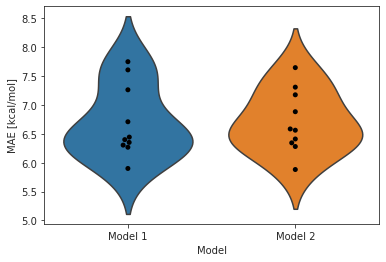

In [17]:
df_onehot = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_per_fold_onehot))],
    *['Model 2' for i in range(len(mae_per_fold_onehot_noBDEs))]
], 'MAE [kcal/mol]': [*mae_per_fold_onehot, *mae_per_fold_onehot_noBDEs]})

df_onehot.to_csv('cross_val_scores_onehot.csv')
plot_cross_val_scores(df_onehot)
plt.show()